# Basline blur classifier model

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import io
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
cuda:0


In [2]:
# ResNet input size
input_size = (224,224)

# Just normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.4853, 0.4290, 0.3761], [0.1348, 0.1184, 0.1311])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.4275, 0.4184, 0.4037], [0.1419, 0.1179, 0.1273])
    ]),
}


## Dataset

In [3]:
class BlurDataset(Dataset):

    def __init__(self, root_dir, imgs_list, transform=None):

        self.root_dir = root_dir
        self.imgs_list = imgs_list
        self.transform = transform

    def __len__(self):
        return len(self.imgs_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Blur kaggle dataset case
        if type(self.imgs_list[idx]) == str:
            img_name = self.imgs_list[idx]
            img_tag = self.imgs_list[idx].split("/")[-1].split("_")[-1].split(".")[0]
            if img_tag == "S":
                img_label = 0
            else:
                img_label = 1
         # VizWiz dataset case
        else:
            img_name = os.path.join(self.root_dir, self.imgs_list[idx][0])
            img_label = self.imgs_list[idx][1]

        image = Image.open(img_name)

        if self.transform:
            sample = self.transform(image)

        return sample, img_label

Load dataset

In [4]:
with open('../data/mixed_vwbk_dataset.json', encoding='UTF-8') as m_json_file:
    data = json.load(m_json_file)
    m_train_data = data["train"]
    m_val_data = data["val"]

In [5]:
batch_size = 64

train_dataset = BlurDataset('/media/arnau/PEN/TFG/train/', m_train_data, data_transforms["train"])
val_dataset = BlurDataset('/media/arnau/PEN/TFG/val/', m_val_data, data_transforms["val"])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

dataloaders_dict = {"train": train_loader, "val": val_loader}

## Training

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.cpu().detach().numpy())

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses

In [7]:
def initialize_model(num_classes):
    # vgg16
    #model = models.vgg16(pretrained=True)
    model = models.convnext_tiny(pretrained=True)
    
    model.fc = nn.Linear(512,num_classes)# YOUR CODE HERE!
    
    input_size = 224
        
    return model, input_size


# Number of classes in the dataset
num_classes = 2

# Initialize the model
model, input_size = initialize_model(num_classes)

# Print the model we just instantiated
print(model)



/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [8]:
# Send the model to GPU
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 5

lr = 2.114132886588899e-05
wd = 2.2379504272114866e-10
optimizer_ft = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 4.9457 Acc: 0.2577
val Loss: 1.8024 Acc: 0.6571

Epoch 1/4
----------
train Loss: 0.8712 Acc: 0.7417
val Loss: 0.4562 Acc: 0.8286

Epoch 2/4
----------
train Loss: 0.3530 Acc: 0.8750
val Loss: 0.3608 Acc: 0.8619

Epoch 3/4
----------
train Loss: 0.2483 Acc: 0.9036
val Loss: 0.3465 Acc: 0.8571

Epoch 4/4
----------
train Loss: 0.2119 Acc: 0.9256
val Loss: 0.3373 Acc: 0.8714

Training complete in 3m 49s
Best val Acc: 0.871429


## Results

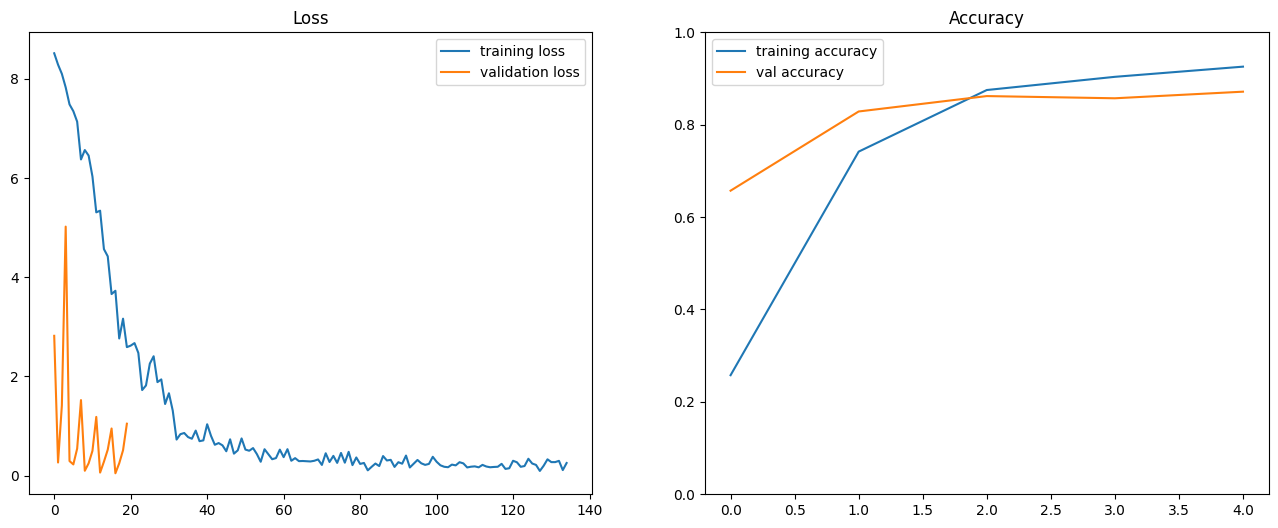

In [13]:
# plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title("Loss")
ax1.plot(losses["train"], label="training loss")
ax1.plot(losses["val"], label="validation loss")
ax1.legend()

ax2.set_title("Accuracy")
ax2.plot([x.cpu().numpy() for x in hist["train"]],label="training accuracy")
ax2.plot([x.cpu().numpy() for x in hist["val"]],label="val accuracy")
ax2.set_ylim([0, 1])
ax2.legend()

plt.show()   

In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate(model, loss_fn, test_loader, device):
    
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        y_true += targets.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / total
    test_f1 = f1_score(y_true, y_pred, average='macro')
    test_precision = precision_score(y_true, y_pred, average='macro')
    test_recall = recall_score(y_true, y_pred, average='macro')

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    print(f"Test Precision: {test_precision * 100:.2f}%")
    print(f"Test Recall: {test_recall * 100:.2f}%")
    print(f"Test F1 Score: {test_f1 * 100:.2f}%")


In [30]:
loss_fn = nn.CrossEntropyLoss()

test_dataset = BlurDataset('/media/arnau/PEN/TFG/val/', data["test"], data_transforms["val"])
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

evaluate(model, loss_fn, test_loader, device)

Test Loss: 0.5463
Test Accuracy: 78.10%
Test Precision: 78.95%
Test Recall: 78.10%
Test F1 Score: 77.93%


## Hyperparemeter tunning

In [16]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize


# Define the objective function to optimize
def objective(trial):
    # Define the hyperparameters to optimize
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    # Define the ConvNetXt model with the hyperparameters
    model = models.convnext_tiny(pretrained=True).to(device)
    
    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Train the model
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.cpu().detach().numpy())

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            acc_history[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)
    
    
    return losses["val"][-1]

# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)
print('Best trial:', study.best_trial.params)

[I 2023-03-27 18:36:23,941] A new study created in memory with name: no-name-4a143062-16b8-4581-be9b-91f3239c9423
/tmp/ipykernel_8154/3185238461.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_8154/3185238461.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arnau/tfg/

Epoch 0/4
----------
train Loss: 1.3623 Acc: 0.6310
val Loss: 0.4703 Acc: 0.7810
Epoch 1/4
----------


[W 2023-03-27 18:37:37,718] Trial 0 failed with parameters: {'lr': 0.0006146087085349979, 'weight_decay': 3.1914439293483957e-09, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8154/3185238461.py", line 50, in objective
    for inputs, labels in dataloaders_dict[phase]:
  File "/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 671, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for 

KeyboardInterrupt: 